In [ ]:
import sys
import sqlite3, csv
from datetime import datetime as dt
import datetime

In [1]:
%load_ext sql

C:\Users\mtags\Anaconda3\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
C:\Users\mtags\Anaconda3\lib\site-packages\IPython\utils\traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [ ]:
%%sql sqlite:///animal_tracker.db
DROP TABLE IF EXISTS animal_tracker_raw;

CREATE TABLE animal_tracker_raw ( 
    actual_lot_size INTEGER, 
    lot_tag_read_count INTEGER, 
    departure_cph TEXT, 
    destination TEXT, 
    read_location_cph TEXT, 
    lot_date DATE, 
    movement_type INTEGER, 
    animal_eid INTEGER, 
    flock_tag INTEGER, 
    tag_count INTEGER, 
    issue_cph TEXT, 
    issue_date DATE, 
    last_update DATE, 
    unique_lot_id INTEGER) 

# Import the data from csv file
the cell below imports the raw data csv file into the **animal_tracker_raw** table.

change the path & filename of the csv file as needed

In [ ]:
conn = sqlite3.connect("animal_tracker.db")

try:

    conn.execute("delete from animal_tracker_raw");

    cur = conn.cursor()

    with open('ExampleData_2016_09_08.xlsx - Relevant_EXAMPLE.csv') as openFile:
        dr = csv.DictReader(openFile)    
        to_db = [(i['Actual lot size'], 
                  i['lot_tag_read_count'],
                  i['departurecph'],
                  i['destination'],
                  i['ReadLocationCPH'],
                  dt.strptime(i['LotDate'], '%m/%d/%Y'),
                  i['MovementType'],
                  i['AnimalEID'],
                  i['Flock_tag'],
                  i['Tag_count'],
                  i['issue_cph'],
                  dt.strptime(i['issue_date'], '%m/%d/%Y'),
                  dt.strptime(i['latest_update'], '%m/%d/%Y'),
                  i['UniqueLotID']
                 ) for i in dr]
        #print(to_db)
        for i in to_db:
            cur.execute("""
            INSERT INTO animal_tracker_raw (
            actual_lot_size,
            lot_tag_read_count,
            departure_cph,
            destination,
            read_location_cph,
            lot_date,
            movement_type,
            animal_eid,
            flock_tag,
            tag_count,
            issue_cph,
            issue_date,
            last_update,
            unique_lot_id 
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);

            """, i)
        
    conn.commit()

except:
    print("Unexpected error:", sys.exc_info()[0])
else:
    conn.close()

print("done")

### data columns 
actual_lot_size - the size of the lot that the animal belongs to (a group as they go to a desitination)?
lot_tag_read_count - the count of animals, within the lot, whose tag was read at the read_location_cph?
departure_cph - where the animal was before the reading location
destination_cph - the location where the animal is going next (a farm, a slaughter house, a shipping port, may leave the system)? after the read location
read_location_cph - the location where the animals tag was read for this record (often at a livestock or similar 3rd party)?
lot_date - the date the tag was read for this animal for this record?
movement_type - some detail about the departure and desitination - farm to farm, farm to slaughter, farm to port? This help identify that the animal has left the system (because it was killed at a slaughter)
animal_eid - the unique identifier for an animal?
flock_tag - a single tag of a full flock/lot - not individual sheep
tag_count - associated with flock tag, the number of animals scanned within the flock with the same flock tag
issue_cph - birth farm of animal, where the tag was issued to the animal
issue_date - date the animal got the tag for the issue_cph
last_update - ???
unique_lot_id - exactly

cph (county/perish/holding)


patient zero tracking
tracking window is to see when the disese started and likely ended
the slower the disease moves, the larger the window

network analysis
degrees of fredom


the result is all the sheep that the animal of interest was in contact with
    possibley of showing a weight of how long they were in contact
    show other animals current location (last scan)
    show on a pretty graph that is easy to understand
    
Also need to identify when a sheep disappeared from the system (due to lack of scanning)





In [ ]:
%%sql sqlite:///animal_tracker.db

select * from animal_tracker_raw

# sheep location duration
below is made-up data as an example of how the raw data should be transformed (TBD)

In [ ]:
%%sql sqlite:///animal_tracker.db
DROP TABLE IF EXISTS animal_location;

CREATE TABLE animal_location(animal_eid INTEGER, location_cph VARCHAR(16), arrival_date DATE, departure_date DATE);


In [ ]:
%%sql sqlite:///animal_tracker.db
DELETE FROM animal_location;
INSERT INTO animal_location VALUES ("s1", "l1", "2016-01-01 12:00:00.000", "2016-02-01 00:00:00.000");
INSERT INTO animal_location VALUES ("s1", "l2", "2016-02-01 12:00:00.000", "2016-05-01 00:00:00.000");

INSERT INTO animal_location VALUES ("s2", "l2", "2016-01-01 12:00:00.000", "2016-03-01 00:00:00.000");
INSERT INTO animal_location VALUES ("s2", "l3", "2016-03-01 12:00:00.000", "2016-05-01 00:00:00.000");

INSERT INTO animal_location VALUES ("s3", "l3", "2016-01-01 12:00:00.000", "2016-04-01 00:00:00.000");
INSERT INTO animal_location VALUES ("s3", "l4", "2016-04-01 12:00:00.000", "2016-05-01 00:00:00.000");

INSERT INTO animal_location VALUES ("s4", "l4", "2016-01-01 12:00:00.000", "2016-05-01 00:00:00.000");

INSERT INTO animal_location VALUES ("s5", "l4", "2016-01-01 12:00:00.000", "2016-02-01 00:00:00.000");
INSERT INTO animal_location VALUES ("s5", "l1", "2016-02-01 12:00:00.000", "2016-05-01 00:00:00.000");



In [32]:
%%sql sqlite:///animal_tracker.db
SELECT * FROM animal_location;

Done.


animal_eid,location_cph,arrival_date,departure_date
s1,l1,2016-01-01 12:00:00.000,2016-02-01 00:00:00.000
s1,l2,2016-02-01 12:00:00.000,2016-05-01 00:00:00.000
s2,l2,2016-01-01 12:00:00.000,2016-03-01 00:00:00.000
s2,l3,2016-03-01 12:00:00.000,2016-05-01 00:00:00.000
s3,l3,2016-01-01 12:00:00.000,2016-04-01 00:00:00.000
s3,l4,2016-04-01 12:00:00.000,2016-05-01 00:00:00.000
s4,l4,2016-01-01 12:00:00.000,2016-05-01 00:00:00.000
s5,l4,2016-01-01 12:00:00.000,2016-02-01 00:00:00.000
s5,l1,2016-02-01 12:00:00.000,2016-05-01 00:00:00.000


# end sheep location duration

## algorithm to find affected sheep

In [2]:
%%sql sqlite:///animal_tracker.db
DROP TABLE IF EXISTS exposure_incident;
CREATE TABLE exposure_incident ( 
    giver_animal_eid INTEGER, 
    location_cph VARCHAR(16), 
    location_exposure_date TIMESTAMP, 
    receiver_animal_eid INTEGER, 
    animal_exposure_date TIMESTAMP 
);


Done.
Done.


[]

In [3]:
import sys
import sqlite3, csv
import copy
from datetime import datetime as dt
import datetime

dbpath = "animal_tracker.db"

def process_exposures():
    isNewRecordsCreated = False
    results_ei_giver = conn.execute("SELECT * FROM exposure_incident")            
    for row_giver in results_ei_giver.fetchall():
        #print(row_giver['receiver_animal_eid'] + "\t" + row_giver['animal_exposure_date'])

        results_ei_receiver = conn.execute(" \
            select locq.giver_animal_eid, locq.location_cph, locq.location_exposure_date, shpq.animal_eid as receiver_animal_eid, \
                CASE WHEN arrival_date > locq.location_exposure_date then arrival_date else locq.location_exposure_date end AS animal_exposure_date from animal_location shpq, \
            (select animal_eid as giver_animal_eid, location_cph, min(CASE WHEN arrival_date > ? then arrival_date else ? end) AS location_exposure_date \
            from animal_location where animal_eid = ? and departure_date >= ? GROUP BY animal_eid, location_cph) as locq \
            where shpq.location_cph = locq.location_cph and shpq.departure_date > locq.location_exposure_date", \
            (row_giver['animal_exposure_date'], row_giver['animal_exposure_date'], row_giver['receiver_animal_eid'], row_giver['animal_exposure_date'], ))
        for row_receiver in results_ei_receiver:
            #print(row_receiver[0] + "\t" + row_receiver[1] + "\t" + row_receiver[2] + "\t" + row_receiver[3] + "\t" + row_receiver[4])
            
            doInsertRecord = True
            cursor = conn.cursor()
            #check that the giver and receiver animal arent the same
            if row_receiver['giver_animal_eid'] == row_receiver['receiver_animal_eid']:
                doInsertRecord = False

            #check that you arent exposing an animal that exposed you
            cursor.execute( \
                "SELECT giver_animal_eid FROM exposure_incident \
                WHERE giver_animal_eid = ? AND receiver_animal_eid = ? LIMIT 1", \
                (row_receiver['receiver_animal_eid'], row_receiver['giver_animal_eid'],))
            if cursor.fetchone() is not None:
                doInsertRecord = False

            #check to ensure record doesnt exist already
            
            cursor.execute( \
                "SELECT giver_animal_eid FROM exposure_incident \
                WHERE giver_animal_eid = ? AND location_cph = ? AND location_exposure_date = ? AND receiver_animal_eid = ? AND animal_exposure_date = ? LIMIT 1", \
                (row_receiver['giver_animal_eid'], row_receiver['location_cph'], row_receiver['location_exposure_date'], row_receiver['receiver_animal_eid'], row_receiver['animal_exposure_date'],))
            if cursor.fetchone() is not None:
                doInsertRecord = False

            if doInsertRecord:
                conn.execute("INSERT INTO exposure_incident (giver_animal_eid, location_cph, location_exposure_date, receiver_animal_eid, animal_exposure_date) VALUES (?, ?, ?, ?, ?)", \
                    (row_receiver['giver_animal_eid'], row_receiver['location_cph'], row_receiver['location_exposure_date'], row_receiver['receiver_animal_eid'], row_receiver['animal_exposure_date'],))
                isNewRecordsCreated = True
            cursor.close()
            if isNewRecordsCreated:
                process_exposures()
    return 


conn = sqlite3.connect(dbpath)
conn.row_factory = sqlite3.Row
try:

    conn.execute("DELETE FROM exposure_incident")
    conn.execute("INSERT INTO exposure_incident (receiver_animal_eid, animal_exposure_date) VALUES (?, ?)", ('s1', '2016-02-01 00:00:00.000',))

    process_exposures()
    
    print("giver_animal_eid" + "\t" + "location_cph" + "\t" + "location_exposure_date" + "\t" + "receiver_animal_eid" + "\t" + "animal_exposure_date")
    results_ei_final = conn.execute("SELECT * FROM exposure_incident")            
    for row in results_ei_final:
        print(str(row['giver_animal_eid']) + "\t" + str(row['location_cph']) + "\t" + str(row['location_exposure_date']) + "\t" + str(row['receiver_animal_eid']) + "\t" + str(row['animal_exposure_date']))
    
except:
    print("Unexpected error:", sys.exc_info()[0])
else:
    conn.commit() 
    conn.close()


giver_animal_eid	location_cph	location_exposure_date	receiver_animal_eid	animal_exposure_date
None	None	None	s1	2016-02-01 00:00:00.000
s1	l2	2016-02-01 12:00:00.000	s2	2016-02-01 12:00:00.000
s1	l1	2016-02-01 00:00:00.000	s5	2016-02-01 12:00:00.000
s2	l3	2016-03-01 12:00:00.000	s3	2016-03-01 12:00:00.000
s3	l4	2016-04-01 12:00:00.000	s4	2016-04-01 12:00:00.000


In [4]:
%%sql sqlite:///animal_tracker.db
select * from exposure_incident;

Done.


giver_animal_eid,location_cph,location_exposure_date,receiver_animal_eid,animal_exposure_date
None,None,None,s1,2016-02-01 00:00:00.000
s1,l2,2016-02-01 12:00:00.000,s2,2016-02-01 12:00:00.000
s1,l1,2016-02-01 00:00:00.000,s5,2016-02-01 12:00:00.000
s2,l3,2016-03-01 12:00:00.000,s3,2016-03-01 12:00:00.000
s3,l4,2016-04-01 12:00:00.000,s4,2016-04-01 12:00:00.000


736085.0
{'s1->s2': (735995.5, 2), 's2->s3': (736024.5, 3), 's3->s4': (736055.5, 4), 's1->s5': (735995.5, 1)}
{'l3': 3, 'l1': 1, 'l4': 4, 'l2': 2}
['l1', 'l2', 'l3', 'l4']
[1, 2, 3, 4]
[735995.0, 735995.5, 736024.5, 736055.5]
[90.0, 89.5, 60.5, 29.5]


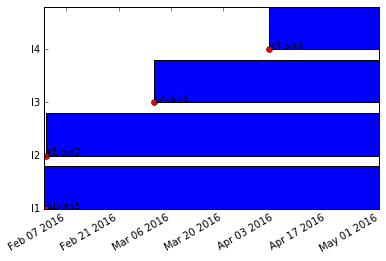

In [3]:
%matplotlib inline

import sys
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime as dt


conn = sqlite3.connect("animal_tracker.db")
#conn.row_factory = sqlite3.Row
#giver_animal_eid	location_cph	location_exposure_date	receiver_animal_eid	animal_exposure_date


results_max_departure_date = conn.execute("SELECT max(departure_date) FROM animal_location")
for row_max_departure_date in results_max_departure_date:
    max_departure_date = mdates.date2num(dt.strptime(row_max_departure_date[0], '%Y-%m-%d %H:%M:%S.%f')) 
print(max_departure_date)

location_names_values = {}

## find the locations
results_loc_exp = conn.execute("SELECT location_cph, min(location_exposure_date) FROM exposure_incident WHERE location_cph != 'None' GROUP BY location_cph ORDER BY location_exposure_date")
loc_labels = []
loc_rows = []
loc_startdates = []
loc_left = []
loc_enddates = []
loc_row_count = 0
for row_loc_exp in results_loc_exp:
    loc_labels.append(row_loc_exp[0])
    loc_row_count += 1
    location_names_values[row_loc_exp[0]] = loc_row_count
    loc_rows.append(loc_row_count)
    loc_startdate = mdates.date2num(dt.strptime(row_loc_exp[1], '%Y-%m-%d %H:%M:%S.%f'))
    loc_startdates.append(loc_startdate)
        
    loc_enddates.append(max_departure_date - loc_startdate)
##end find the locations


## find the animals
results_animal_exp = conn.execute("SELECT giver_animal_eid, location_cph, receiver_animal_eid, animal_exposure_date FROM exposure_incident WHERE location_cph != 'None' ORDER BY animal_exposure_date")
giver_animal_eids = []
receiver_animal_eids = []
animal_exposure_dates = []
animal_exposure_locs = []

exposure_labels = {}
for row_animal_exp in results_animal_exp:
    animal_exposure_date = mdates.date2num(dt.strptime(row_animal_exp[3], '%Y-%m-%d %H:%M:%S.%f'))
    animal_exposure_dates.append(animal_exposure_date)
    animal_exposure_locs.append(location_names_values[row_animal_exp[1]])
    exposure_labels[row_animal_exp[0] + "->" + row_animal_exp[2]] = (animal_exposure_date, location_names_values[row_animal_exp[1]])
    #ax.annotate(row_animal_exp[0] + "->" + row_animal_exp[2], xy=(animal_exposure_date, location_names_values[row_animal_exp[1]]), textcoords='data')

##end find the animals
print(exposure_labels)
    
conn.close()

print(location_names_values)

print(loc_labels)
print(loc_rows)
print(loc_startdates)
print(loc_enddates)


fig, ax = plt.subplots()


ax.plot(animal_exposure_dates, animal_exposure_locs, 'ro')
ax.barh(loc_rows, loc_enddates, left=loc_startdates )

for label in exposure_labels:
    ax.annotate(label, xy=exposure_labels[label], textcoords='data')

plt.yticks(loc_rows, loc_labels)

ax.axis('tight')
ax.xaxis_date()
fig.autofmt_xdate()

plt.show()

# end algorithm to find affected sheep

# Below are cells that arent needed right now

### Research
Diffusion Model - Set of mathematical equations or formulas that attempts to estimate the spread of information (idea or rumor) or a contagious disease through a population.



Below:
Enter the date for time_of_interest yyyy mm dd
This will query the data and return the records where the issue_date is between the time_of_interest and the time_of_interest + 28 days
It then randomly selects one of the returned records

In [ ]:
from random import randint

time_of_interest = datetime.date(2011, 9, 1)
time_of_interest_end = time_of_interest + datetime.timedelta(days=28)

conn = sqlite3.connect(dbpath)
#
c1 = conn.execute("SELECT * FROM sheep_tracker WHERE lot_date BETWEEN ? AND ?", (time_of_interest, time_of_interest_end,))

all_rows = c1.fetchall()
rows_count = len(all_rows)
if rows_count > 0:
    random_row = all_rows[randint(0, rows_count - 1)]
    print(random_row)
    
    if random_row[5] < : 
    
    
else:
    print("no records found")



conn.close()

In [ ]:
from datetime import datetime as dt
import datetime
newd = dt.strptime('8/14/2010', '%m/%d/%Y')
time_of_interest = datetime.date(2011, 9, 1)
print(newd)
print(time_of_interest)

In [ ]:
%sql sqlite:///C:\\Users\\mtags\\Desktop\\sheep.db
#%sql delete from mydata
%sql select animal_eid, count(*) from sheep_tracker GROUP BY animal_eid

## questions
1.  when selecting an animal within the time of interest, you want the records where the time_of_interest date range (TOI_start, TOI_end) overlaps with the animals time at a lot (lot_date, lot_date_end(need to find this based on next record) )  WHERE (lot_start < TIO_end AND lot_end >= TIO_start
2.  maybe need more data as each animal is only in the data once.  Or I can make some up.
3.  what will be the format of the outputs - fancy graphs or just data


# Chris's algorithm

1.  process raw data to show a sheepid, location, arrival date, departure date
    * this is where some data can be fudged to estimate lost data
2.  by selecting a sheep and a date range (disregarding the data outside of the range), determine which other sheep the primary sheep interacted with by matching locations and date overlaps
3.  (optional) apply a weight to how closely related the other sheep were to the primary sheep
    *  if sheep2 spent the whole date range with the primary sheep, then 1
    *  if only spent half the time then 0.5
    *  for each degree of separation the weight is further divided by 2 (* 0.5)
4.  show in fancy chart

In [ ]:
#this was just used to fine tune my query to find exposure_incident
%sql sqlite:///C:\\Users\\mtags\\Desktop\\sheep.db

%sql select locq.*, shpq.animal_eid as animal_eid_receiver, CASE WHEN arrival_date > locq.loc_exposure_date then arrival_date else locq.loc_exposure_date end AS animal_exposure_date from sheep_location shpq, \
    (select animal_eid as animal_eid_giver, location_cph, min(CASE WHEN arrival_date > '2016-02-01' then arrival_date else '2016-02-01' end) AS loc_exposure_date \
    from sheep_location where animal_eid = 's1' and departure_date >= '2016-02-01' GROUP BY animal_eid, location_cph) as locq \
    where shpq.location_cph = locq.location_cph and shpq.departure_date > locq.loc_exposure_date;

# %sql select *, location_cph, min(CASE WHEN arrival_date > '2016-02-01' then arrival_date else '2016-02-01' end) AS exposure_date \
#     from sheep_location where animal_eid = 's1' and departure_date >= '2016-02-01' ;


In [ ]:
%sql sqlite:///C:\\Users\\mtags\\Desktop\\sheep.db

        
# %sql select * from sheep_location


%sql  select locq.giver_animal_eid, locq.location_cph, locq.location_exposure_date, shpq.animal_eid as receiver_animal_eid, CASE WHEN arrival_date > locq.location_exposure_date then arrival_date else locq.location_exposure_date end AS animal_exposure_date from sheep_location shpq, \
            (select animal_eid as giver_animal_eid, location_cph, min(CASE WHEN arrival_date > '2016-04-01 12:00:00.000' then arrival_date else '2016-04-01 12:00:00.000' end) AS location_exposure_date \
            from sheep_location where animal_eid = 's4' and departure_date >= '2016-04-01 12:00:00.000' GROUP BY animal_eid, location_cph) as locq \
            where shpq.location_cph = locq.location_cph and shpq.departure_date > locq.location_exposure_date
        
# %sql select animal_eid as giver_animal_eid, location_cph, min(CASE WHEN arrival_date > '2016-02-01 00:00:00.000' then arrival_date else '2016-02-01 00:00:00.000' end) AS location_exposure_date \
#             from sheep_location where animal_eid = 's1' and departure_date >= '2016-02-01 00:00:00.000' GROUP BY animal_eid, location_cph
    
# %sql select * from sheep_location \
#     where departure_date >= '2016-02-01 00:00:00.000'

In [ ]:
#I think this is an old algorithm but want to hand onto it just in case 2016-09-21 14:46

def dosomething(conn, infected_sheeps):
    print("entering dosomething")
    new_rec_found = False
    infected_loc_dict = {}
    # 1. identify the infected sheep
    for infected_sheep in infected_sheeps:
        # 2. store all the locations that the infected sheep(s) was at and the date range that the location was infected
        
        results = conn.execute( \
            "SELECT location_cph, min(arrival_date) FROM sheep_location WHERE animal_eid = ? AND departure_date >= ? GROUP BY location_cph", \
                (infected_sheep, infected_sheeps[infected_sheep]))
        for row in results:
            infected_loc_dict[row[0]] = row[1];
            

    print(infected_loc_dict)    
    #infected_sheeps = {};
# 3. search all sheep for the infected location/time range
    for loc in infected_loc_dict:
        #print(loc + " " + infected_loc_dict[loc])
        resultsR2 = conn.execute(\
            "SELECT animal_eid, min(arrival_date) FROM sheep_location WHERE location_cph = ? AND departure_date >= ? GROUP BY animal_eid", \
                (loc, infected_loc_dict[loc],))
        
        #print('aaa' + str(infected_sheeps))
        for rowR2 in resultsR2:
            print('ddd' + str(rowR2))
            if rowR2[0] not in infected_sheeps or infected_sheeps[rowR2[0]] > rowR2[1]:
                #print(str(rowR2[0] not in infected_sheeps))                
                #if rowR2[0] in infected_sheeps:
                    #print('\t' + str(infected_sheeps[rowR2[0]] > rowR2[1]))
                
                infected_sheeps[rowR2[0]] = rowR2[1]                
                new_rec_found = True
    if new_rec_found:
        print(infected_sheeps)
        infected_sheeps = dosomething(conn, infected_sheeps)
            
    return infected_sheeps



connX = sqlite3.connect(dbpath)

#try:
#d = datetime.date(2016, 1, 1)
s = '2016-04-01'
print(d)
infected_sheeps = {'s1': s}

infected_sheeps_result = dosomething(connX, infected_sheeps)
print(infected_sheeps_result)
#except:
print("Unexpected error:", sys.exc_info()[0])
#else:
connX.close()


In [ ]:
from IPython.core.display import display, HTML
display(HTML('<span style="color:red;">Hello, world!</span>'))

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot([2, 3, 2], [4, 4, 2], 'r^:')
plt.plot([1, 2, 3], [1, 2, 3], 'gs-')
plt.axis([0, 5, 0, 10])
plt.ylabel('some numbers')
plt.show()